## First Aproach

- Simular $n$ termoeléctricas ($t_i$ es el valor de generación máxima de la termoeléctrica $i$)
- El día 0 funcionan todas
- Si todas funcionan Oferta $\geq$ Demanda
- Simular tiempo de rotura (Weibull)
- Todas se pueden reparar a la vez
- Tiempo de reparación Lognormal
- Existen $m$ circuitos ($c_j$ es el valor de demanda del circuito $j$)
- $\delta_{ik}$ es un parámetro binario que expresa si la termoeléctrica $i$ está activa el día $k$
- $\alpha_{jk}$ es un parámetro binario que expresa si el circuito $j$ está activo el día $k$
- Existe capacidad de almacenamiento ($a_k$ es la capacidad de almacenamiento del sistema en el día $k$)
- $a_0 = 0$
- $a_k = \sum_{i=1}^{n} t_i\delta_{ik} + a_{k-1} - \sum_{j=1}^{m} c_j\alpha_{jk}, a_k \geq 0$
- No simularemos mantenimientos planificados, solo reparación por rotura
- No tendremos en cuenta fallas internas de los circuitos
- No habrán circuitos que dependan de termoeléctricas específicas
- La afectación a los circuitos se hará de manera proporcional (con una proporción que definiremos) y rotativa, cuando sea necesario
- Al final de la simulación calcularemos una afectación (fórmula por determinar)


In [109]:
from App.modules.weibull import Weibull
from App.modules.lognormal import LogNormal
from App.modules.event import Event
from App.modules.thermoelectric import ThermoElectric
from App.modules.agents import Agent
from App.modules.circuit import Circuit
from App.modules.roundrobin import RoundRobin
import random as rnd
import numpy as np
import copy
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, Markdown


In [110]:
def generate_thermoelectrics(days, thermoelectrics_amount):
    thermoelectrics = []
    for i in range(thermoelectrics_amount):
        w = Weibull(rnd.uniform(40, 70), rnd.uniform(1, 3))
        l = LogNormal(rnd.uniform(2, 2.5), rnd.uniform(0.2, 0.4))
        o = rnd.randrange(200, 1000)
        t = ThermoElectric(o, w, l)
        t.planificate_events(days)
        thermoelectrics.append(t)

    return thermoelectrics

In [111]:
days = 365
thermoelectrics_amount = 20
stored_energy = 0
thermoelectrics = generate_thermoelectrics(days, thermoelectrics_amount)

In [112]:
def generate_circuits(circuits_amount, days):
    circuits = []
    for i in range(circuits_amount):
        demand = rnd.lognormvariate(rnd.uniform(0, 7), rnd.uniform(0.2, 0.4))
        c = Circuit(i, demand, days)
        circuits.append(c)

    return circuits


# Initialize circuits
circuits_amount = 115
circuits = generate_circuits(circuits_amount, days)

In [113]:
for i in range(1):
    print(i)
    thermoelectrics[i].plot(0, 365)
    thermoelectrics[i].get_distributions_info()

0
360
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Weibull Distribution:
Scale: 58.22241632647594
Shape: 1.0328966727271707

LogNormal Distribution:
Mean: 2.282634947608027Des: 0.3492937397270428


In [114]:
def get_next_general_event(thermoelectrics_list, days, current_day):
    next_event = days
    next_thermoelectric = None
    for t in thermoelectrics_list:
        tmp = t.get_next_future_event_day()
        if tmp < next_event and tmp >= current_day:
            next_event = tmp
            next_thermoelectric = t
    return (next_event, next_thermoelectric)

In [115]:
def simulate(
    thermoelectrics: "list[ThermoElectric]",
    days,
    agent: Agent = None,
    circuits: "list[Circuit]" = None,
    stored_energy=None,
    rotation=RoundRobin(),
):
    """returns working_thermoelectrics, defict per day, stored energy, circuits"""

    working_thermoelectrics = []

    working_thermoelectrics.append(np.ones(len(thermoelectrics)))

    deficit_per_day = []

    deficit_per_day.append(0)

    stored_energy_per_day = []

    stored_energy_per_day.append(0)

    total_demand = 0

    if circuits is not None:

        total_demand = sum([c.demand for c in circuits])

    event_date, event_thermoelectric = get_next_general_event(thermoelectrics, days, 0)

    for current_day in range(0, days):

        if agent is not None:

            agent.Manage_Thermoelectrics(
                current_day, stored_energy, circuits, thermoelectrics, rotation
            )

        while event_thermoelectric != None and np.floor(event_date) == current_day:

            event_thermoelectric.pop_next_future_event()

            event_date, event_thermoelectric = get_next_general_event(
                thermoelectrics, days, current_day
            )

        thermoelectrics_state = [t.is_working() for t in thermoelectrics]

        working_thermoelectrics.append(thermoelectrics_state)

        if circuits is not None:

            if agent is not None:

                agent.Manage_Circuits(
                    current_day, stored_energy, circuits, thermoelectrics, rotation
                )

            total_offer = (
                sum([x.offer for x in thermoelectrics if x.is_working()])
                + stored_energy_per_day[-1]
            )

            deficit_today = max(total_demand - total_offer, 0)

            deficit_per_day.append(deficit_today)

            stored_energy = max(total_offer - total_demand, 0)

            stored_energy_per_day.append(stored_energy)

    return working_thermoelectrics, deficit_per_day, stored_energy_per_day, circuits

In [116]:
tmp = copy.deepcopy(thermoelectrics)
tmp_circuits = copy.deepcopy(circuits)


(
    working_thermoelectrics_without_strategy,
    deficit_per_day_without_strategy,
    stored_energy_without_strategy,
    circuits_without_strategy,
) = simulate(tmp, days, circuits=tmp_circuits, stored_energy=stored_energy)


working_thermoelectrics_without_strategy = [
    sum(x) for x in working_thermoelectrics_without_strategy
]



fig_without_heuristic = go.Figure()



fig_without_heuristic.add_trace(

    go.Scatter(
        x=list(range(0, days)),
        y=working_thermoelectrics_without_strategy,
        mode="lines",
    )
)



fig_without_heuristic.update_layout(
    title="Working thermoelectrics per day",
    xaxis_title="Days",
    yaxis_title="Working thermoelectrics",
)



fig_without_heuristic = go.Figure()

fig_without_heuristic.add_trace(
    go.Scatter(
        x=list(range(0, days)),
        y=stored_energy_without_strategy,
        mode="lines",
        name="Stored Energy",
    )
)
fig_without_heuristic.add_trace(
    go.Scatter(
        x=list(range(0, days)),
        y=deficit_per_day_without_strategy,
        mode="lines",
        name="Deficit",
    )
)

fig_without_heuristic.update_layout(
    title="Energy per day",
    xaxis_title="Days",
    yaxis_title="Energy",
)


fig_without_heuristic.show()

In [117]:
def get_deficit_and_stored_energy(circuits, thermoelectrics, stored_energy):
    total_demand = sum([x.demand for x in circuits])
    total_offer = (
        sum([x.offer for x in thermoelectrics if x.is_working()]) + stored_energy
    )
    return (
        (total_demand - total_offer, 0)
        if total_demand > total_offer
        else (0, total_offer - total_demand)
    )

# Agent with thermoelectric maintenance strategy


In [118]:
def average_worktime(planification, days, amount):

    total_sum = 0
    total_intervals = 0

    for i in range(amount):
        sum = 0
        for j in range(days):
            if planification[j][i]:
                sum += 1
            elif sum != 0:
                total_sum += sum
                total_intervals += 1
                sum = 0
        if sum != 0:
            total_sum += sum
            total_intervals += 1
            sum = 0
    return total_sum, total_intervals

In [119]:
def k_simulation(days, thermoelectrics_amount, k, agent=None, circuits_amount=0):
    """returns working day average, thermoelectics average by day, deficit average by day, stored energy by day"""
    sum_time = 0
    intervals = 0

    average_active_thermoelectric = 0
    average_deficit = 0
    average_stored_energy = 0

    total_working_thermoelectrics_per_day = np.zeros(days + 1)
    total_deficit_per_day = np.zeros(days + 1)
    total_stored_energy_per_day = np.zeros(days + 1)

    for i in range(k):
        thermoelectrics = generate_thermoelectrics(days, thermoelectrics_amount)
        circuits = (
            None if circuits_amount <= 0 else generate_circuits(circuits_amount, days)
        )
        (
            thermoelectrics_state,
            deficit_per_day,
            stored_energy_per_day,
            circuits_result,
        ) = simulate(thermoelectrics, days, agent, circuits)
        (
            partial_sum_working_thermoelectrics,
            partial_intervals_working_thermoelectrics,
        ) = average_worktime(thermoelectrics_state, days, thermoelectrics_amount)

        sum_time += partial_sum_working_thermoelectrics
        intervals += partial_intervals_working_thermoelectrics

        number_of_working_thermoelectrics_current_simulation = [
            sum(x) for x in thermoelectrics_state
        ]

        total_working_thermoelectrics_per_day += np.array(
            number_of_working_thermoelectrics_current_simulation
        )
        total_deficit_per_day += np.array(deficit_per_day)
        total_stored_energy_per_day += np.array(stored_energy_per_day)

        average_active_thermoelectric += sum(
            number_of_working_thermoelectrics_current_simulation
        )
        average_deficit += sum(deficit_per_day)
        average_stored_energy += sum(stored_energy_per_day)

    working_average = sum_time / intervals if intervals != 0 else 0
    total_working_thermoelectrics_per_day /= k
    total_deficit_per_day /= k
    total_stored_energy_per_day /= k

    average_active_thermoelectric /= k * days
    average_deficit /= k * days
    average_stored_energy /= k * days

    return (
        working_average,
        total_working_thermoelectrics_per_day,
        total_deficit_per_day,
        total_stored_energy_per_day,
        average_active_thermoelectric,
        average_deficit,
        average_stored_energy,
    )

In [120]:
tmp_thermoelectrics_maintenance = copy.deepcopy(thermoelectrics)
tmp_circuits_maintenance = copy.deepcopy(circuits)

average, _, _, _, _, _, _ = k_simulation(
    days, 20, 10, circuits_amount=len(tmp_circuits_maintenance)
)


def give_maintenance_heuristic(
    current_day,
    stored_energy,
    circuits: "list[Circuit]",
    thermoelectrics: "list[ThermoElectric]",
    rotation: "RoundRobin",
):
    for thermoelectric in thermoelectrics:
        if not thermoelectric.is_working():
            continue
        last_repair = thermoelectric.get_last_repair_day()
        if current_day - last_repair >= average:
            thermoelectric.repair_and_replanificate(
                current_day,
                days,
                LogNormal(rnd.uniform(1.5, 2), rnd.uniform(0.2, 0.4)),
            )


def empty_func(arg0, arg1, arg2, arg3, rg4):
    pass


(
    working_thermoelectrics_maintenance_heuristic,
    deficit_per_day_maintenance_heuristic,
    stored_per_day_maintenance_heuristic,
    circuits_maintenance_heuristic,
) = simulate(
    tmp_thermoelectrics_maintenance,
    days,
    Agent(
        give_maintenance_heuristic,
        empty_func,
    ),
    tmp_circuits_maintenance,
    stored_energy,
)
working_thermoelectrics_maintenance_heuristic = [
    sum(x) for x in working_thermoelectrics_maintenance_heuristic
]

fig_maintenance_heuristic = go.Figure()
fig_maintenance_heuristic.add_trace(
    go.Scatter(
        x=list(range(0, days)),
        y=working_thermoelectrics_maintenance_heuristic,
        mode="lines",
    )
)
fig_maintenance_heuristic.update_layout(
    title="Maintenance heuristic",
    xaxis_title="Days",
    yaxis_title="Working thermoelectrics",
)

fig_maintenance_heuristic.show()

fig_energy_deficit_and_stored_maintenance_heuristic = go.Figure()

fig_energy_deficit_and_stored_maintenance_heuristic.add_trace(
    go.Scatter(
        x=list(range(0, days)),
        y=stored_per_day_maintenance_heuristic,
        name="Stored Energy",
    )
)

fig_energy_deficit_and_stored_maintenance_heuristic.add_trace(
    go.Scatter(
        x=list(range(0, days)),
        y=deficit_per_day_maintenance_heuristic,
        name="Deficit Energy",
    )
)


fig_energy_deficit_and_stored_maintenance_heuristic.update_layout(
    title="Energy per day",
    xaxis_title="Days",
    yaxis_title="Energy",
    legend=dict(x=0.7, y=0.95),
    showlegend=True,
)

# Agent with circuit strategies


In [121]:
rotation = RoundRobin()


def disconnect_circuit_heuristic(
    current_day,
    stored_energy,
    circuits: "list[Circuit]",
    thermoelectrics: "list[ThermoElectric]",
    rotation: "RoundRobin",
):
    deficit, stored_energy = get_deficit_and_stored_energy(
        circuits, thermoelectrics, stored_energy
    )
    while deficit > 0:
        circuit = circuits[rotation.next() % len(circuits)]
        if deficit > 1 / 4 * circuit.demand:
            circuit.disconnect(1 / 4, current_day)
        else:
            circuit.disconnect(deficit / circuit.demand, current_day)
        deficit -= circuit.demand / 4 if deficit > 1 / 4 * circuit.demand else deficit

In [122]:
tmp_thermoelectrics = copy.deepcopy(thermoelectrics)
tmp_circuits = copy.deepcopy(circuits)

(
    working_thermoelectrics_both_heuristic,
    deficit_per_day_both_heuristic,
    stored_energy_per_day_both_heuristic,
    circuits_result,
) = simulate(
    tmp_thermoelectrics,
    days,
    Agent(
        give_maintenance_heuristic,
        disconnect_circuit_heuristic,
    ),
    tmp_circuits,
    stored_energy,
)
working_thermoelectrics_both_heuristic = [
    sum(x) for x in working_thermoelectrics_both_heuristic
]


fig_both_heuristic = go.Figure()
fig_both_heuristic.add_trace(
    go.Scatter(
        x=list(range(0, days)),
        y=working_thermoelectrics_both_heuristic,
        mode="lines",
    )
)
fig_both_heuristic.update_layout(
    title="Maintenance heuristic and disconnect circuit heuristic",
    xaxis_title="Days",
    yaxis_title="Working thermoelectrics",
)

fig_both_heuristic.show()


fig_energy_deficit_and_stored = go.Figure()


fig_energy_deficit_and_stored.add_trace(
    go.Scatter(
        x=list(range(0, days)),
        y=stored_energy_per_day_both_heuristic,
        mode="lines",
        name="Energy Stored per day",
    )
)

fig_energy_deficit_and_stored.add_trace(
    go.Scatter(
        x=list(range(0, days)),
        y=deficit_per_day_both_heuristic,
        mode="lines",
        name="Energy Deficit per day",
    )
)

fig_energy_deficit_and_stored.update_layout(
    title="Energy per day",
    xaxis_title="Days",
    yaxis_title="Energy",
    legend=dict(x=0.7, y=0.95),
    showlegend=True,
)


fig_energy_deficit_and_stored.show()

# Maintenance VS Non Maintenance


In [123]:
list_of_days = list(range(0, days))
fig_comparison_working_thermoelectrics = go.Figure()
fig_comparison_working_thermoelectrics.add_trace(
    go.Scatter(
        x=list_of_days,
        y=working_thermoelectrics_maintenance_heuristic,
        mode="lines",
        name="Maintenance Strategy",
    )
)

fig_comparison_working_thermoelectrics.add_trace(
    go.Scatter(
        x=list_of_days,
        y=working_thermoelectrics_without_strategy,
        mode="lines",
        name="Without Maintenance Strategy",
    )
)

fig_comparison_energy = go.Figure()

fig_comparison_energy.add_trace(
    go.Scatter(
        x=list_of_days,
        y=stored_per_day_maintenance_heuristic,
        mode="lines",
        name="Maintenance Strategy",
    )
)

fig_comparison_energy.add_trace(
    go.Scatter(
        x=list_of_days,
        y=stored_energy_without_strategy,
        mode="lines",
        name="Without Maintenance Strategy",
    )
)

fig_comparison_deficit = go.Figure()

fig_comparison_deficit.add_trace(
    go.Scatter(
        x=list_of_days,
        y=deficit_per_day_maintenance_heuristic,
        mode="lines",
        name="Maintenance Strategy",
    )
)

fig_comparison_deficit.add_trace(
    go.Scatter(
        x=list_of_days,
        y=deficit_per_day_without_strategy,
        mode="lines",
        name="Without Maintenance Strategy",
    )
)

fig_comparison_working_thermoelectrics.update_layout(
    title="Working Thermoelectric per day",
    xaxis_title="Days",
    yaxis_title="Thermoeelctrics",
    legend=dict(x=0.7, y=0.95),
    showlegend=True,
)


fig_comparison_energy.update_layout(
    title="Stored Energy per day",
    xaxis_title="Days",
    yaxis_title="Energy",
    legend=dict(x=0.7, y=0.95),
    showlegend=True,
)


fig_comparison_deficit.update_layout(
    title="Deficit per day",
    xaxis_title="Days",
    yaxis_title="Energy",
    legend=dict(x=0.7, y=0.95),
    showlegend=True,
)

fig_comparison_working_thermoelectrics.show()
fig_comparison_energy.show()
fig_comparison_deficit.show()

## Repeat experiments


In [124]:
# number of simulations
K_SIMULATIONS = 1

# non maintenance
(
    _,
    non_maintenance_average_of_working_per_day,
    non_maintenance_average_deficit_per_day,
    non_maintenance_average_stored_energy_per_day,
    non_maintenance_average_of_working,
    non_maintenance_average_deficit,
    non_maintenance_average_stored_energy,
) = k_simulation(days, thermoelectrics_amount, K_SIMULATIONS, None, circuits_amount)

# maintenance
(
    _,
    maintenance_average_of_working_per_day,
    maintenance_average_deficit_per_day,
    maintenance_average_stored_energy_per_day,
    maintenance_average_of_working,
    maintenance_average_deficit,
    maintenance_average_stored_energy,
) = k_simulation(
    days,
    thermoelectrics_amount,
    K_SIMULATIONS,
    Agent(give_maintenance_heuristic, empty_func),
    circuits_amount,
)

## print estadistics in md format

display(
    Markdown(
        f"""### Non Maintenance
Average in {K_SIMULATIONS} simulations:

`Working Thermoelectrics:` {non_maintenance_average_of_working}

`Deficit:` {non_maintenance_average_deficit}

`Stored Energy:` {non_maintenance_average_stored_energy}
"""
    )
)

display(
    Markdown(
        f"""### Maintenance
Average in {K_SIMULATIONS} simulations:

`Working Thermoelectrics:` {maintenance_average_of_working}

`Deficit:` {maintenance_average_deficit}

`Stored Energy:` {maintenance_average_stored_energy}
"""
    )
)


display(
    Markdown(
        f"""### Maintenance vs Non Maintenance
Average day in {K_SIMULATIONS} simulations"""
    )
)


list_of_days = list(range(days))

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=list_of_days,
        y=non_maintenance_average_of_working_per_day,
        name="Non Maintenance",
    )
)

fig.add_trace(
    go.Scatter(
        x=list_of_days, y=maintenance_average_of_working_per_day, name="Maintenance"
    )
)

fig.update_layout(
    title="Maintenance vs Non Maintenance: Average Working Thermoelectrics",
    xaxis_title="Days",
    yaxis_title="Working Thermoelectrics",
    legend=dict(x=0.7, y=0.95),
    showlegend=True,
)
fig.show()

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=list_of_days,
        y=non_maintenance_average_deficit_per_day,
        name="Non Maintenance",
    )
)
fig.add_trace(
    go.Scatter(
        x=list_of_days, y=maintenance_average_deficit_per_day, name="Maintenance"
    )
)

fig.update_layout(
    title="Maintenance vs Non Maintenance: Average Deficit",
    xaxis_title="Days",
    yaxis_title="Energy",
    legend=dict(x=0.7, y=0.95),
    showlegend=True,
)

fig.show()

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=list_of_days,
        y=non_maintenance_average_stored_energy_per_day,
        name="Non Maintenance",
    )
)
fig.add_trace(
    go.Scatter(
        x=list_of_days, y=maintenance_average_stored_energy_per_day, name="Maintenance"
    )
)

fig.update_layout(
    title="Maintenance vs Non Maintenance: Stored Energy",
    xaxis_title="Days",
    yaxis_title="Energy",
    legend=dict(x=0.7, y=0.95),
    showlegend=True,
)

fig.show()

### Non Maintenance
Average in 1 simulations:

`Working Thermoelectrics:` 15.92876712328767

`Deficit:` 11853.029817070883

`Stored Energy:` 0.0


### Maintenance
Average in 1 simulations:

`Working Thermoelectrics:` 14.33972602739726

`Deficit:` 9112.270842884107

`Stored Energy:` 0.0


### *Maintenance vs Non Maintenance*
Average day in 1 simulations

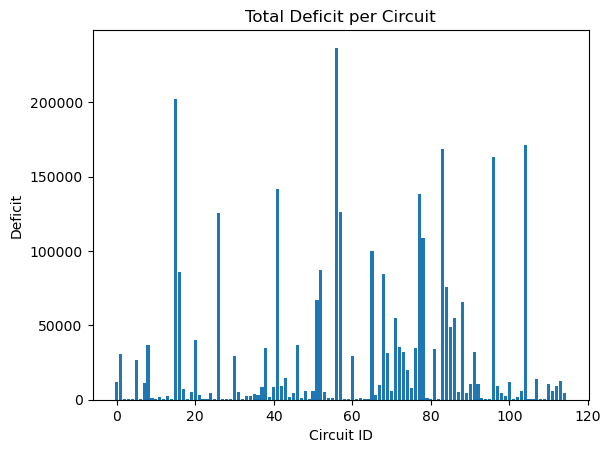

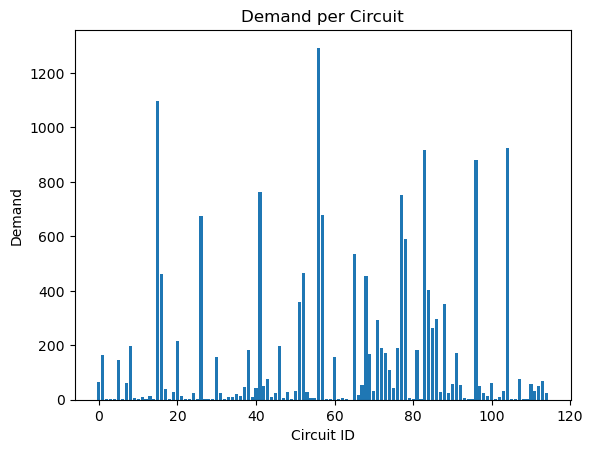

In [125]:
total_deficit_by_circuit = [x.total_deficit for x in circuits_result]
demand_by_circuit = [x.demand for x in circuits_result]
x = list(range(len(total_deficit_by_circuit)))

plt.bar(x, total_deficit_by_circuit)
plt.ylabel("Deficit")
plt.xlabel("Circuit ID")
plt.title("Total Deficit per Circuit")
plt.show()

plt.bar(x, demand_by_circuit)
plt.ylabel("Demand")
plt.xlabel("Circuit ID")
plt.title("Demand per Circuit")
plt.show()

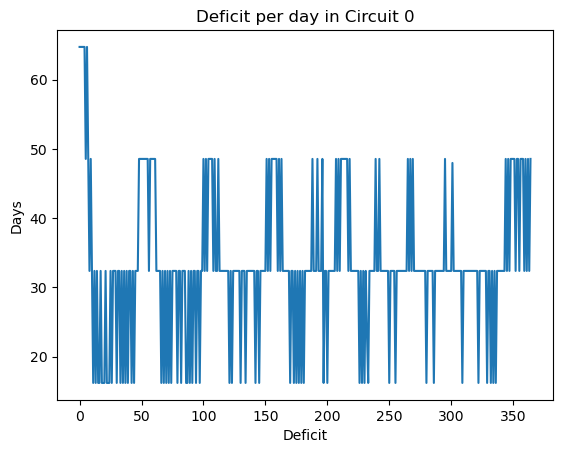

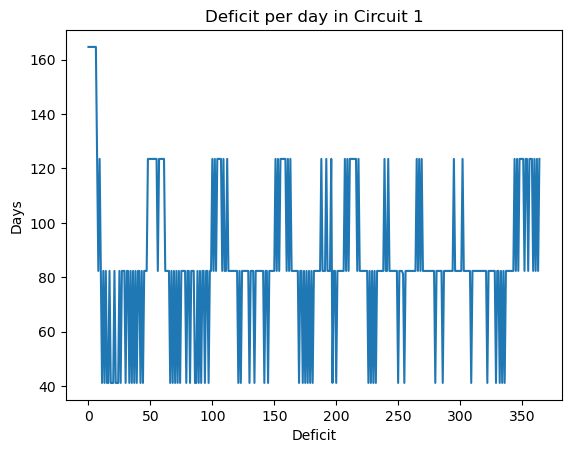

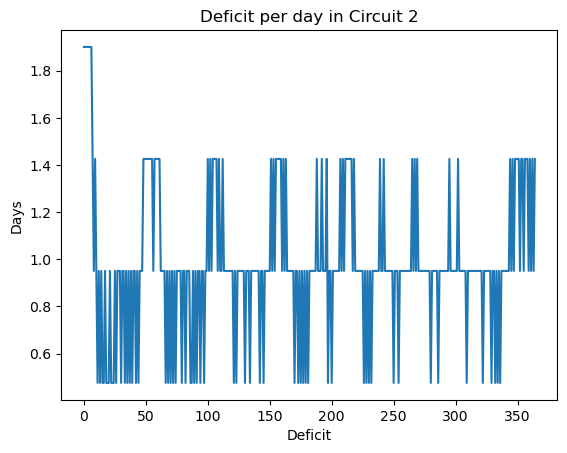

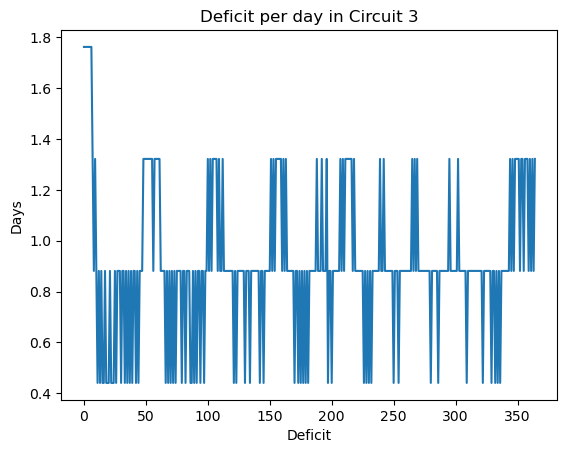

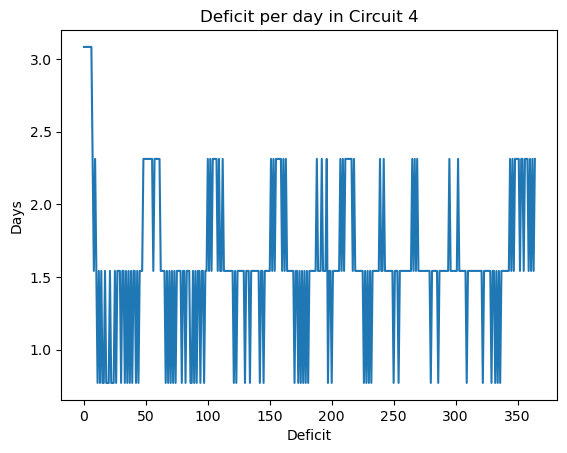

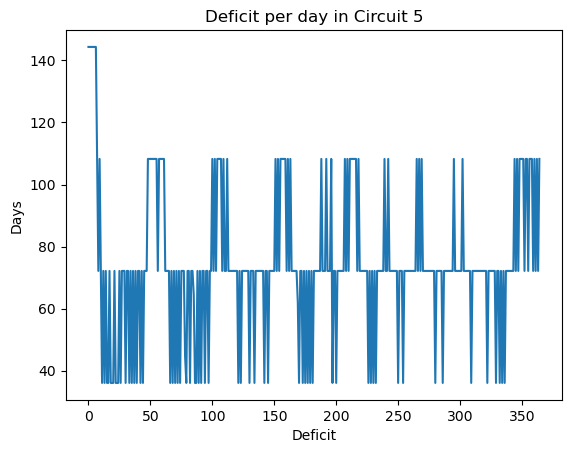

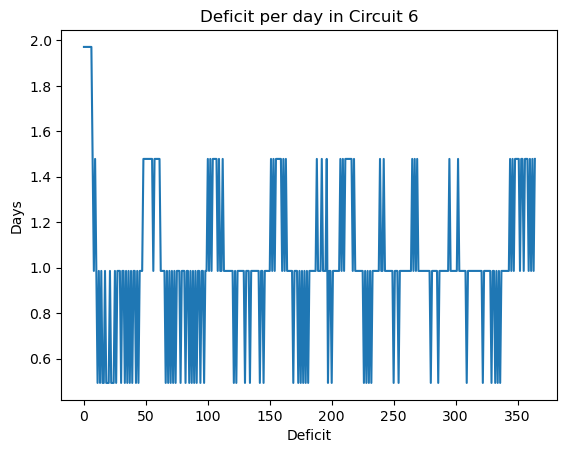

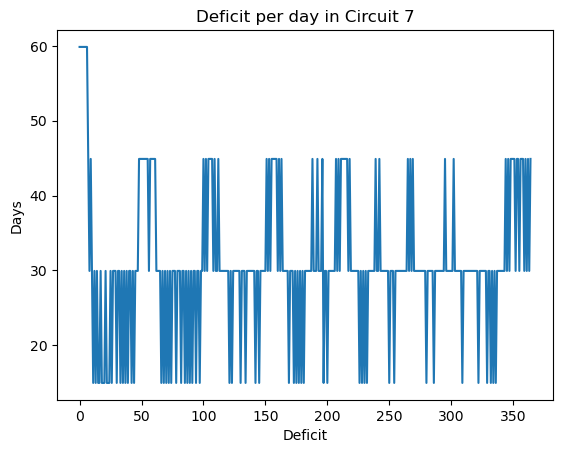

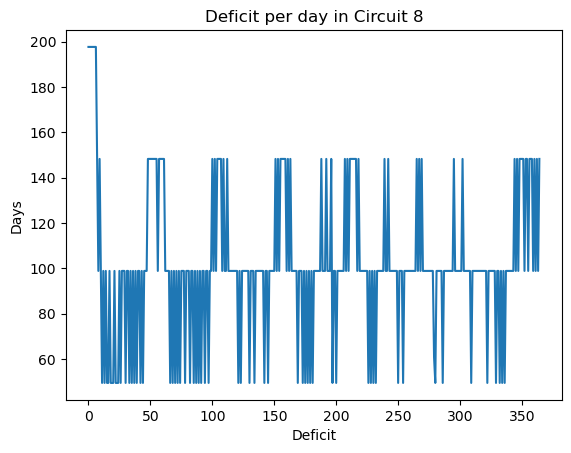

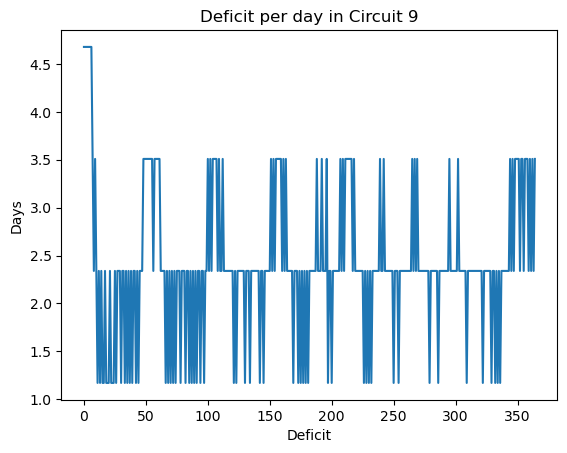

In [126]:
for c in circuits_result[:10]:
    plt.plot(c.deficit_history)
    plt.title(f"Deficit per day in Circuit {c.id}")
    plt.xlabel("Deficit")
    plt.ylabel("Days")
    plt.show()